# Проект: "Защита персональных данных клиентов"

Проект нацелен на защиту данных клиентов страховой компании «Хоть потоп». 

В работе разработан метод, который преобразовывает данные, чтобы по ним было сложно восстановить персональную информацию. Обоснованна корректность работы данного метода.
Данные защищены и трансформированны таким образом, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. 

![](https://digital.report/wp-content/uploads/2016/04/Personalnyie-dannyie-Retina-1078x516.jpg)

# Импорт данных

**Импорт библиотек**

In [70]:
import pandas as pd

import numpy as np
from numpy.linalg import inv

# conda install -c conda-forge phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

In [2]:
#Исмпорт данных
bank_data = pd.read_csv('./insurance.csv')
bank_data

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


**Для удобства переимменуем заголовки столбцов**

In [3]:
bank_data = bank_data.rename(
    columns={'Пол':'Sex',
             'Возраст':'Age', 
             'Зарплата':'Salary',
             'Члены семьи':'Family parts',
             'Страховые выплаты':'Insurance payments'})
print('')
print('Общий вид заголовков таблицы:')
bank_data.head(0)


Общий вид заголовков таблицы:


,Sex,Age,Salary,Family parts,Insurance payments


**Описание данных:**

- Признаки: 
    - пол: 1 - мужской, 0 - женский;
    - возраст;
    - зарплата застрахованного;
    - количество членов его семьи.
- Целевой признак: 
    - количество страховых выплат клиенту за последние 5 лет.

# Препроцессинг данных

In [4]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sex                 5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family parts        5000 non-null   int64  
 4   Insurance payments  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


**Анализ данных на пропуски в значениях:**


Пропуски в данных отсутствуют.

## Анализ данных на мультиколлинеарность

**Построим матрицу корреляции признаков**

Для этого используем библиотеку **phik**

interval columns not set, guessing: ['Sex', 'Age', 'Salary', 'Family parts', 'Insurance payments']


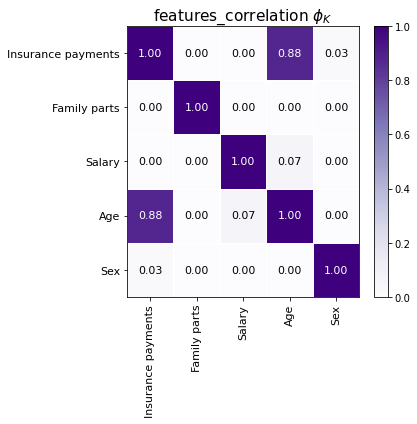

In [5]:
#Матрица корреляции
phik_bank_data = bank_data.phik_matrix()
#Визуализация матрицы 𝜙k 
plot_correlation_matrix(
    phik_bank_data.round(2).values, 
    x_labels=phik_bank_data.columns, 
    y_labels=phik_bank_data.index, 
    vmin=0, vmax=1, color_map="Purples", 
    title=r"features_correlation $\phi_K$", 
    fontsize_factor=1.1,
    figsize=(6, 6))

**На базе приведенной матрицы корреляции можно сделать следующие выводы:**
1) Целевой признак имеет сильную корреляцию с  возрастом клиента. Одновременно с этим мало коррелирует с полом человека, и никак не связан с количеством членов семьи и зарплатой клиента.

2) Среди признаков видна взаимосвязь между возрастом и зарплатой клиентов. (Учтем эту зависимость при предобработке данных).

## Выявление дубликатов

In [6]:
duplicates_quantity = bank_data.duplicated().sum()
print(f'Количество дубликатов в датафрейме: {duplicates_quantity}')

Количество дубликатов в датафрейме: 153


In [7]:
#Удаление дубликатов
bank_data = bank_data.drop_duplicates()
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sex                 4847 non-null   int64  
 1   Age                 4847 non-null   float64
 2   Salary              4847 non-null   float64
 3   Family parts        4847 non-null   int64  
 4   Insurance payments  4847 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 227.2 KB


**Удалено 153 дубликата.**

## Исследование признаков

**Исследуем статистические характеристики каждого признака**

In [8]:
bank_data.describe()

,Sex,Age,Salary,Family parts,Insurance payments
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


### Famili parts

Text(0, 0.5, 'Кол-во клиентов')

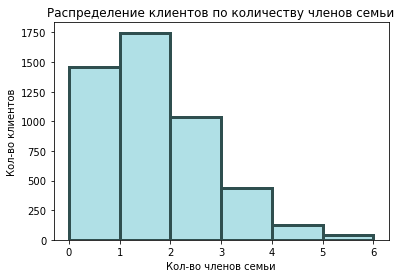

In [9]:
plt.hist(bank_data['Family parts'], 
         bins=bank_data['Family parts'].max(),
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 3,
)
plt.title("Распределение клиентов по количеству членов семьи")
plt.xlabel("Кол-во членов семьи")
plt.ylabel("Кол-во клиентов")



**Анализ графика распределения по признаку "Family parts"**

- Наибольшее количество клиентов (1750 человек) имеет 2-ух детей;
- Распределение выражено распределнием Пуассона и не имеет выраженных аномалий и выбросов. Удаление выбросов не целесообрасзно.

### Salary

**Построим график распределения зарплат в зависимости от возраста**

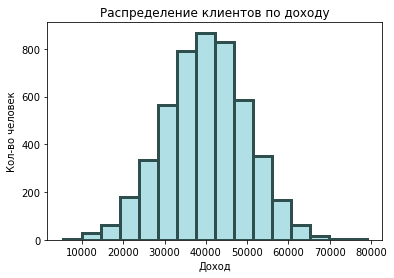

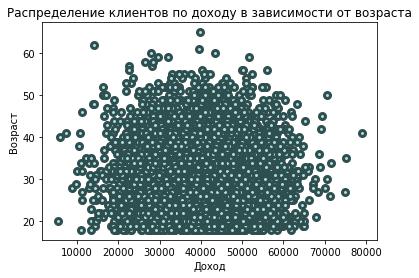

In [10]:
#График распределения доходов клиентов
x = bank_data['Salary']
plt.hist(bank_data['Salary'], 
         bins=16,
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 3,
)
plt.title("Распределение клиентов по доходу")
plt.xlabel("Доход")
plt.ylabel("Кол-во человек")
plt.show()

#График распределения доходов клиентов в 
#зависимости от возраста
plt.scatter(bank_data['Salary'],
            bank_data['Age'],
            color = 'powderblue',
            edgecolor='darkslategray',
            linewidth = 3
)
plt.title("Распределение клиентов по доходу в зависимости от возраста")
plt.xlabel("Доход")
plt.ylabel("Возраст")
plt.show()

**Анализ графика распределения по признаку "Salary"**

- Наибольшее количество клиентов имеют доход в районе 40.000;
- Распределение выражено Нормальным распределением и не имеет выраженных аномалий и выбросов. Удаление выбросов не целесообрасзно.
- Видна слабая корреляция между доходом и возрастом. На базе графиков распределения видна концентрация среднего дохода у людей в среднем возрасте от 20 до 50 лет.Эта корреляция будет кчтена дальше в разделе с ML.

### Age

Text(0, 0.5, 'Кол-во клиентов')

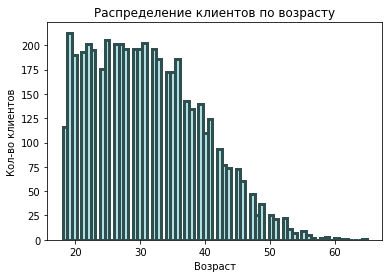

In [11]:
plt.hist(bank_data['Age'], 
         bins=int(bank_data['Age'].max()),
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 3,
)
plt.title("Распределение клиентов по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Кол-во клиентов")

**Анализ графика распределения по признаку "Age"**

- Наибольшее количество клиентов находятся в возрастном диапазоне от 20 до 35 лет;
- Распределение выражено распределением Пуассона и не имеет выраженных аномалий и выбросов. Удаление выбросов не целесообрасзно.

### Sex

Text(0, 0.5, 'Кол-во клиентов')

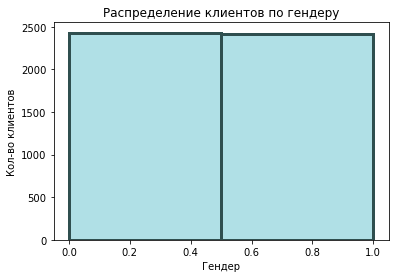

In [12]:
plt.hist(bank_data['Sex'], 
         bins=2,
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 3,
)
plt.title("Распределение клиентов по гендеру")
plt.xlabel("Гендер")
plt.ylabel("Кол-во клиентов")

**Анализ графика распределения по признаку "Sex"**

- В датафрейме не наблюдается дисбаланс классов по параметру 'Sex';


## Вывод
 
По итогу предобработки данных в датафрейме обнаружено и удалено 153 дубликата. Пропуски и неадекватные значения в датафрейме отсутствуют, а данные имеют ожидаемое статистическое распределение.
Все признаки имеют правильные форматы данных и не коллинеарны друг-другу.


# Умножение матриц

Признаки умножают на обратимую матрицу. Необходимо проверить, изменится ли качество линейной регрессии и показать, как связаны параметры линейной регрессии в исходной задаче и в преобразованной. 

Качество линейной регресси определяется вектором предсказаний a. Задачу можно свести к анализу изменения вектора предсказания а. Возможно 2 варианта:

    1) a изменится.
    2) a не изменится.

**Дано:**

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Задача:**

Ихменится ли a если 
$$
Х_1=ХР
$$

**Обозначения:**

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

**Решение:**

**1)** Если матрицу признаков умножают на обратимую матрицу то:
$$
X_1 = XP
$$
Тогда:
$$
a_1 = X_1w
$$
$$
a_1 = XPw
$$

**Свойства матриц:**

1) $(AB)^{-1} = (B)^{-1}(A)^{-1}$

2) $A(A)^{-1} = E$

3) $(AB)^{T} = B^{T}A^{T}$
 

**2)** Выразим вектор предсказания через формулу обучения модели для Х и $X_1$

Формула обучения для $X_1$:

$$
w = (X_1^T X_1)^{-1} X_1^T y
$$

Выполним подстановку $X_1 = XP$:

$$
w = ((XP)^T XP)^{-1} (XP)^T y
$$

$$
a_1 = XP((XP)^T XP)^{-1} (XP)^T y
$$

$$
a_1 = XP(P^{T}X^{T}XP)^{-1}  (XP)^T y
$$

$$
a_1 = XPP^{-1}(X^{T}X)^{-1}(P^{T})^{-1}  P^TX^T y
$$

где: $PP^{-1}=E $ и $ (P^{T})^{-1}  P^T = E $

$$
a_1 = XE(X^{T}X)^{-1} EX^T y
$$

$$
a_1 = X(X^{T}X)^{-1} X^T y
$$

$$
a_1 = X(X^{T}X)^{-1} X^T X X^{-1} y
$$

$$
a_1 = X(X^{T}X)^{-1} (X^T X) X^{-1} y
$$

где: $(X^{T}X)^{-1} (X^T X) = E $

$$
a_1 = XE X^{-1} y
$$

$$
a_1 = EE y
$$

Формула обучения для $X$:

$$
w = (X^T X)^{-1} X^T y
$$

$$
a = X((X)^T X)^{-1} (X)^T y
$$

$$
a = X(X)^{-1}((X)^T)^{-1}  (X)^T y
$$

$$
a = X(X^{T}X)^{-1} X^T X X^{-1} y
$$

$$
a = X(X^{T}X)^{-1} (X^T X) X^{-1} y
$$

где: $(X^{T}X)^{-1} (X^T X) = E $

$$
a = XE X^{-1} y
$$

$$
a = EE y
$$

$$
a = EE y
$$

**3)** Из предыдущего пункта доказательства видно, что $a_1 = a$.


**Вывод:**
Качество линейной регресси при умножении матрицы признаков на обратимую матрицу не изменяется.

# Алгоритм преобразования

В предыдущем разделе доказано, что качество линейной регресси при умножении матрицы признаков на обратимую матрицу не изменяется. Применим это свойство при трансформации данных во время обучения модели. При этом алгоритм будет выглядеть следующим образом:

    1) Разделение призанков на обучающие и целевой;
    2) Создание класса, который будет выполнять преобразование данных внутри себя и на выходе выдавать зашифровванные признаки;
    3) Выполнение преобразоаввния исходных данных для их зашифровки внутри класса, путем умножения матрицы признаков на рандомную обратимую матрицу размером 4х4 (4 обучающих признака);
    4) Обучение модели и предсказание целевого признака на зашифрованных данных;
    5) Определение качества модели через коэффициента детерминации R2 для зашифрованных данных;
    6) Определение качества модели через коэффициента детерминации R2 для незашифрованных данных;
    7) Сравнение коэффициента детерминации R2 для обоих случаев.

# Проверка алгоритма

**Разделение признаков на таргет и фичи**

In [16]:
features = bank_data.drop('Insurance payments', axis =1)
target = bank_data['Insurance payments']

## Алгоритм трансформации данных

**Рандомная обратимая матрица**

In [73]:
#create NumPy matrix of random integers
P = np.random.randint (0, 100, (4, 4))
print('Рандоманя обратимая матрица:')
print(P)
# Проверка на обратимость
print('Матрица обратная рандомной:')
print(np.linalg.inv(P))

Рандоманя обратимая матрица:
[[92 11 95 73]
 [98 44  2 29]
 [33 62 16 86]
 [91  6 18 45]]
Оматрица обратная рандомной:
[[-0.00048746  0.00644299 -0.00510477  0.00639441]
 [ 0.00399635  0.01981039  0.00395543 -0.02680892]
 [ 0.01470857  0.00506505 -0.00439132 -0.01873241]
 [-0.00543052 -0.01769655  0.01155212  0.02035879]]


**Проверка на обратимость**

In [62]:
print('Оматрица обратная рандомной:', P^(-1))
P

Оматрица обратная рандомной: [[-36  -2 -78 -26]
 [-62 -51 -54 -14]
 [-36 -42 -19 -64]
 [-62 -82 -65 -61]]


array([[35,  1, 77, 25],
       [61, 50, 53, 13],
       [35, 41, 18, 63],
       [61, 81, 64, 60]])

**Разработка класса для зашифровки данных**

In [52]:
class data_encryption():
    
    def fit(self, features):
        X = features
        self.X= X.astype('int').values
        return self

    def encoding(self, matrix):
        P = matrix
        encoded_data = np.dot(self.X, P)
        
        #convert NumPy array to pandas DataFrame
        encoded_data = pd.DataFrame(data=encoded_data)
        return encoded_data


In [55]:
encription = data_encryption().fit(features)
encripted_feat = encription.encoding(P)
encripted_feat.head()


,0,1,2,3
0,1738597,2035732,895114,3125418
1,1332867,1560381,686502,2394658
2,736769,862450,379537,1323377
3,1460903,1710912,751841,2627493
4,915243,1071501,471361,1644689


## Обучение модели

### C исходными признаками

In [60]:
lin_reg = LinearRegression()
lin_reg.fit(features, target)
predict = lin_reg.predict(features)
r_2 = r2_score (target, predict).round(4)
print(f'Коэффициент детерминации для модели обученной на незашифрованных данных: {r_2}')

Коэффициент детерминации для модели обученной на незашифрованных данных: 0.4302


### C трансформированными признаками

In [59]:
lin_reg = LinearRegression()
lin_reg.fit(encripted_feat, target)
predict = lin_reg.predict(encripted_feat)
r_2 = r2_score (target, predict).round(4)
print(f'Коэффициент детерминации для модели обученной на зашифрованных данных: {r_2}')

Коэффициент детерминации для модели обученной на зашифрованных данных: 0.4302


## Вывод

**Коэффициенты детерминации для моделей обученных на зашифрованных и незашифрованных данных равны. Это доказывает правильность и работоспособность выбранного алгоритма.**

# Вывод

В проекте была поставлена задача о разработке алгоритма по зашифровке персональных данных клиентов банка.

В ходе ее решения были выполнены следующие шаги:
- Изучены исходные данные. Проведен их анализ на качество, который показал, что данные адекватны, и могут быть использованы для работы. 
- Удалены дубликаты в исходном датасете.
- Была доказана гипотеза о том, что если матрицу признаков умножить на рандомную обратимую матрицу, то предсказания качество работы модели линейной регрессии останется неизменным. 
- На основании этого свойства, был разработан алгоритм, зашифровывающий всю персональную информацию клиентов, который может быть использован при предсказании страховых выплат.